# Fruit & Vegetables Freshness Classification

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## <span style='background :LemonChiffon' > Prepare dataset </span>

### Set parameters and load dataset

In [37]:
from tensorflow.keras.utils import image_dataset_from_directory

batch_size = 32
img_height = 224
img_width = 224
img_size = (img_height, img_width)
img_shape = img_size + (3,)

# Edit according to local path for dataset
ds_path = r"initial_data"

train_ds = image_dataset_from_directory(ds_path,
                                        validation_split = 0.2,
                                        subset = "training",
                                        seed = 123,
                                        image_size = img_size,
                                        batch_size = batch_size)

val_ds = image_dataset_from_directory(ds_path,
                                      validation_split = 0.2,
                                      subset = "validation",
                                      seed = 123,
                                      image_size = img_size,
                                      batch_size = batch_size)

Found 12107 files belonging to 8 classes.
Using 9686 files for training.
Found 12107 files belonging to 8 classes.
Using 2421 files for validation.


In [3]:
class_names = train_ds.class_names
num_classes = len(class_names)

print(class_names)

['fresh_apple', 'fresh_banana', 'fresh_orange', 'fresh_tomato', 'stale_apple', 'stale_banana', 'stale_orange', 'stale_tomato']


### Sample images

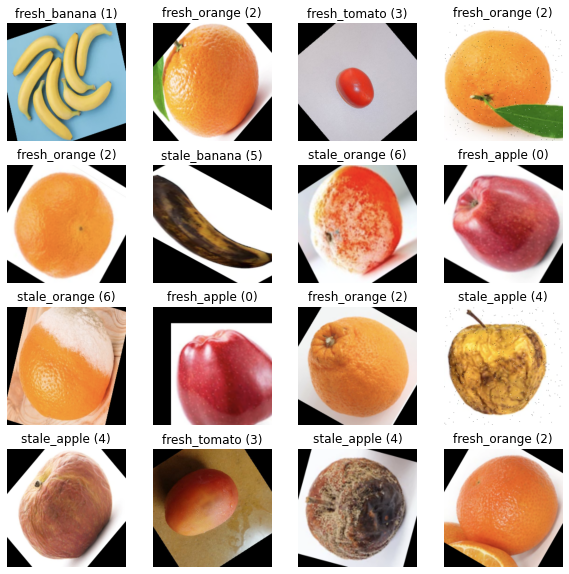

In [28]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]] + ' ({})'.format(labels[i]))
        plt.axis("off")

### Create test set

In [5]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_dataset = val_ds.take(val_batches // 5)
validation_dataset = val_ds.skip(val_batches // 5)

In [6]:
# Buffered prefetching
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size = AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size = AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size = AUTOTUNE)

## <span style='background :LemonChiffon' > Building the model </span>

### Using transfer learning
Run one of the three following cells to choose from the ResNet50, MobileNetV2, and InceptionV3 pre-trained models. 

* ResNet50

In [ ]:
# Create ResNet50 base model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

pre_trained_model = ResNet50(input_shape = img_shape,
                        include_top = False,
                        weights = 'imagenet')

pre_trained_model.trainable = False

* MobileNetV2

In [7]:
# Create MobileNetV2 base model 
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

pre_trained_model = MobileNetV2(input_shape = img_shape,
                        include_top = False,
                        weights = 'imagenet')

pre_trained_model.trainable = False

* InceptionV3

In [ ]:
# Create InceptionV3 base model
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

pre_trained_model = InceptionV3(input_shape = img_shape,
                        include_top = False,
                        weights = 'imagenet')

pre_trained_model.trainable = False

In [9]:
# Base model architecture
pre_trained_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

### Add classification head and compile model

In [10]:
# Averaging layer
global_average = tf.keras.layers.GlobalAveragePooling2D()

# Data augmentation 
augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2)
])

# Add dense layer
prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax')

# Chain model 
inputs = tf.keras.Input(shape = img_shape)
# x = augmentation(inputs) # Uncomment to apply augmentation
x = preprocess_input(inputs)
x = pre_trained_model(x, training=False)
x = global_average(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs,outputs)

# Compile model
lr = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
              metrics=['accuracy'])

# Display model architecture
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

### Building model from scratch
Run the following cell to build model from scratch, for transfer learning run the above cells.

In [39]:
# Preprocessing
data_augmentation = tf.keras.Sequential([ 
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2)
])
    
rescale = tf.keras.layers.Rescaling(1./255) 
    
# Convolutional neural network
cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', input_shape=img_shape),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Chain model
inputs = tf.keras.Input(shape = img_shape)
x = data_augmentation(inputs) 
x = rescale(x)
outputs = cnn(x)
model = tf.keras.Model(inputs,outputs)
    
# Compile model
lr = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
              metrics=['accuracy'])

# Display model architecture
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 sequential_2 (Sequential)   (None, 8)                 2469000   
                                                                 
Total params: 2,469,000
Trainable params: 2,469,000
Non-trainable params: 0
_________________________________________________________________


## <span style='background :LemonChiffon' > Model training </span>

In [8]:
# Callback function
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.95):
            print("\nReached 95% accuracy so cancelling training!")
            self.model.stop_training = True
            
callbacks = myCallback()

In [41]:
epoch = 1

history = model.fit(
            train_ds,
            validation_data = val_ds,
            epochs = epoch,
            callbacks=[callbacks])

303/303 [==============================] - 887s 3s/step - loss: 0.8963 - accuracy: 0.6665 - val_loss: 0.4785 - val_accuracy: 0.8298


### Training Evaluation

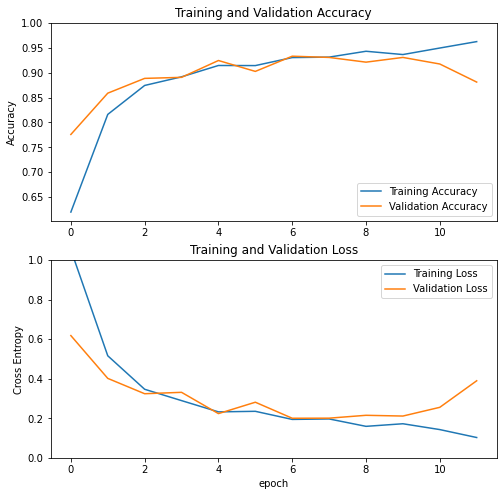

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## <span style='background :LemonChiffon' > Predicting images </span>

In [13]:
# Upload image to be predicted
from ipywidgets import FileUpload

upload = FileUpload()
upload

FileUpload(value={}, description='Upload')

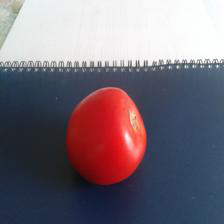

In [50]:
# Display image
import io
from PIL import Image

for name, file_info in upload.value.items():
    pic = Image.open(io.BytesIO(file_info['content']))

pic

In [51]:
# Normalize and resize image
x = np.array(pic)
x = tf.image.resize(x, [img_height, img_width])
x = np.expand_dims(x, axis=0)

# Predict image class
pred_img = model.predict(x)
pred_idx = np.argmax(pred_img, axis=-1)

print("It's a {}!".format(class_names[int(pred_idx)]))
print(pred_idx)
print(pred_img)

1/1 [==============================] - 0s 42ms/step
It's a fresh_tomato!
[3]
[[9.0474998e-05 7.8168485e-09 6.1747681e-07 9.1067725e-01 1.6165370e-05
  3.2792052e-06 7.4899649e-06 8.9204766e-02]]


### Confusion Matrix

1/1 [==============================] - 0s 465ms/step


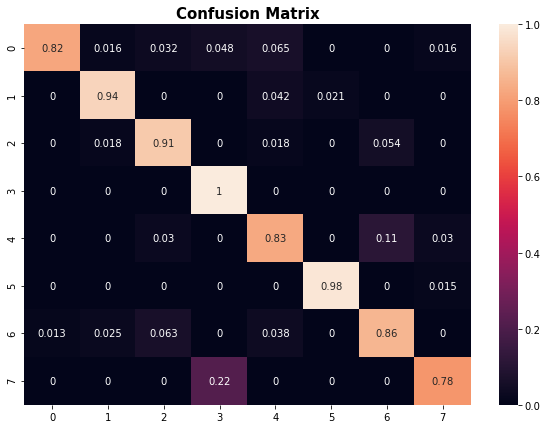

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

predicted = []  # predicted labels
true = []  # true labels

for image_batch, label_batch in test_dataset:  
    true.append(label_batch)
    prediction = model.predict(image_batch)
    predicted.append(np.argmax(prediction, axis=-1))

# convert labels into tensors
true_labels = tf.concat([item for item in true], axis=0)
predicted_labels = tf.concat([item for item in predicted], axis=0)

cf_matrix = confusion_matrix(true_labels, predicted_labels, normalize='true')

# plot confusion  matrix
plt.figure(figsize = (10,7))
sns.heatmap(cf_matrix, 
            annot=True)
plt.title('Confusion Matrix', size=15, fontweight='bold')
plt.show()